# Analyzing and Visualizing Recalls 2011-2022

In [1]:
import os, glob
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Loading data. Each year of recalls is stored in csv file
files = glob.glob('recalls-clean-2022*.csv')
df_list = []
for file in files:
    df = pd.read_csv(file)
    df_list.append(df)

recalls = pd.concat(df_list, axis=0, ignore_index=True)

recalls.drop(['Unnamed: 0'], axis=1, inplace=True)
recalls.reset_index(inplace=True, drop=True)
recalls['date'] = pd.to_datetime(recalls.date, format='%Y-%m-%d')
recalls.sort_values('date', inplace=True, ascending=False)

recalls['hazard_type'].loc[recalls['hazard_type'].str.contains(r'Microbial contamination', na=False)] = 'Microbiological'

C:\Users\Ale\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [2]:
recalls.shape

(3893, 11)

In [3]:
# recalls.hazard.value_counts().to_frame().reset_index().sort_values('hazard', ascending=False)

## Recalls per Class

In [4]:
class_recall = recalls.recall_class.value_counts(normalize=True).head(3).to_frame()
class_recall.head()
# class_recall.to_csv('recalls-class.csv')

,recall_class
Class 1,0.354839
Class 2,0.322323
Class 3,0.313806


# Recalls per Year

In [5]:
no_recalls = recalls['date'].dt.year.value_counts().to_frame().reset_index().sort_values('index').reset_index(drop=True)
avg_recalls = no_recalls.iloc[:11]
# avg_recalls['date'].mean()
# avg_recalls.to_csv('recalls-per-year.csv')
avg_recalls

,index,date
0,2011,401
1,2012,386
2,2013,398
3,2014,547
4,2015,357
5,2016,379
6,2017,305
7,2018,267
8,2019,279
9,2020,212


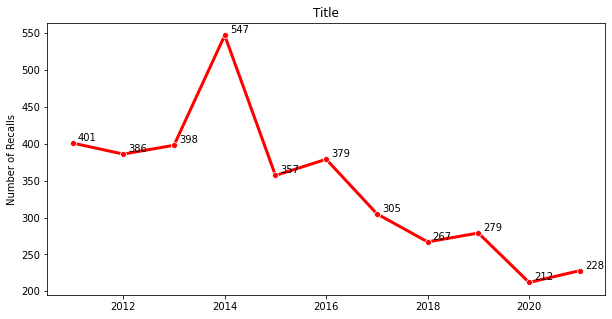

In [6]:
plt.figure(figsize=(10,5))
# plt.plot('index|', 'date', data=avg_recalls)
ax= sns.lineplot(x='index', y='date', data=avg_recalls, linewidth=3, color='red', marker='o')
plt.ylabel('Number of Recalls')
plt.xlabel('')
plt.title('Title')

# label points on the plot
for x, y in zip(avg_recalls['index'], avg_recalls['date']):
    plt.text(x = x+0.1, # x-coordinate position of data label
             y = y+3, # y-coordinate position of data label, adjusted to be 150 below the data point
             s = '{:.0f}'.format(y), # data label, formatted to ignore decimals
             color = 'black') # set colour of line
# plt.xticks(avg_recalls.index)
# ax.set_xticks(range(len(avg_recalls)))
# ax.set_xticklabels(avg_recalls['index'], minor=False, rotation=45)

## Recalls per Hazard

In [7]:
year_recalls = recalls.copy()

year_recalls['year'] = year_recalls['date'].dt.year
year_recalls['month'] = year_recalls['date'].dt.month_name()

year_recalls = year_recalls.groupby(['year', 'hazard_type'])['hazard_type'].size().to_frame()
year_recalls.rename(columns={'hazard_type': 'count'}, inplace=True)
year_recalls.reset_index(inplace=True)
year_recalls = year_recalls[year_recalls.hazard_type.isin(['Allergen', 'Chemical', 'Extraneous Material', 'Microbiological'])].sort_values(['year', 'count'])
# year_recalls.to_csv('recalls-per-year-type.csv')

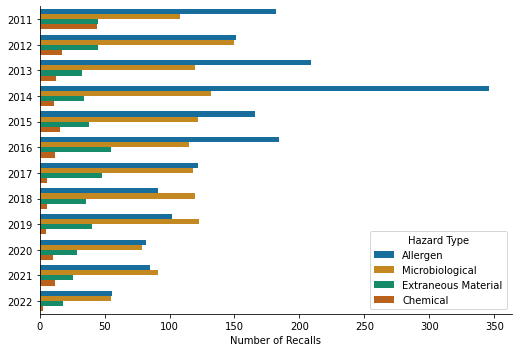

In [8]:
ax = sns.catplot(x='count', 
                 y='year', 
                 hue='hazard_type', 
                 kind='bar',
                 orient='h',
                 data=year_recalls, 
                 height=5, 
                 aspect=1.5,
                 hue_order=['Allergen', 'Microbiological', 'Extraneous Material', 'Chemical'],
                 legend=False,
                 palette='colorblind')
plt.xlabel('Number of Recalls')
plt.ylabel('')
plt.legend(title='Hazard Type')

In [9]:
type_recalls = recalls['hazard_type'].value_counts(normalize=True).to_frame().reset_index().head()
type_recalls.sort_values('hazard_type', inplace=True, ascending=False)
# type_recalls.to_csv('recalls-type.csv')

In [10]:
diff = 1-type_recalls.hazard_type.sum()

In [11]:
type_recalls.iloc[4:5,1:2] = 0.025944 + diff
type_recalls

,index,hazard_type
0,Allergen,0.456203
1,Microbiological,0.342409
2,Extraneous Material,0.114821
3,Chemical,0.039815
4,Other,0.046751


## Explode Hazard and Distribution (Transform each element separated by a comma, replicating index values in the dataframe).

In [12]:
recalls_clean = recalls.copy()
recalls_clean['hazard_explode'] = recalls_clean.hazard.str.split(',')
recalls_clean['distribution_explode'] = recalls_clean.distribution.str.split(',')

recalls_explode = recalls_clean.explode('hazard_explode').explode('distribution_explode').reset_index()

recalls_explode.drop(columns=['hazard', 'distribution'], inplace=True)
recalls_explode = recalls_explode.rename(columns={'level_0': 'index_clean', 'index':'index_links',
                                 'hazard_explode':'hazard', 'distribution_explode':'distribution'})

recalls_explode['hazard'] = recalls_explode.hazard.str.strip().str.capitalize()
recalls_explode['distribution'] = recalls_explode.distribution.str.strip()

In [13]:
# Selecting relevant columns
recalls_explode = recalls_explode[['index_clean', 'index_links', 'title',
                             'date','hazard_type', 'hazard', 'recall_class','audience',
                             'distribution','brand','product', 'company']]

### Final Clean on Distribution Column

In [14]:
# This function is based on a text cleaning function developed by Matt Harrison.

def generalize(ser, match_name, default=None, regex=False, case=False):
    """ Search a series for text matches.
    Based on code from https://www.metasnake.com/blog/pydata-assign.html

    ser: pandas series to search
    match_name: tuple containing text to search for and text to use for normalization
    default: If no match, use this to provide a default value, otherwise use the original text
    regex: Boolean to indicate if match_name contains a  regular expression
    case: Case sensitive search

    Returns a pandas series with the matched value

    """
    seen = None
    for match, name in match_name:
        mask = ser.str.contains(match, case=case, regex=regex)
        if seen is None:
            seen = mask
        else:
            seen |= mask
        ser = ser.where(~mask, name)
    if default:
        ser = ser.where(seen, default)
    else:
        ser = ser.where(seen, ser.values)
    return ser



distribution_patterns = [('Newfoundl', 'New Foundland and Labrador'),
                         ('Labrador', 'New Foundland and Labrador'),
                         ('Prince Edward Isl', 'Prince Edward Island'),
                         ('British Colombia', 'British Columbia')]

### Final Clean on Hazard column

In [15]:
hazard_patterns = [('Yeasts', 'Quality/spoilage'), ('Yeast', 'Quality/spoilage'),
                   ('Walnuts', 'Walnut'), ('T?ree nuts', 'Tree nut'), ('Sulp?ites', 'Sulphites'),
                   ('Sanitizer residue', 'Sanitizer'), ('Rock', 'Rocks'),
                   ('Toxin patulin', 'Patulin'), ('Pistachios', 'Pistachio'),
                   ('Peanuts', 'Peanut'), ('Moulds', 'Quality/spoilage'), ('Mould', 'Quality/spoilage'),
                   ('Hazelnuts', 'Hazelnut'), ('Eggs', 'Egg'), ('Cashews', 'Cashew'),
                   ('Almonds', 'Almond')]

In [16]:
# Apply generalize function 
recalls_explode['distribution'] = generalize(recalls_explode['distribution'], distribution_patterns,  default=None, regex=True, case=False)

In [17]:
# Apply generalize function 
recalls_explode.hazard.fillna('', inplace=True)
recalls_explode['hazard'] = generalize(recalls_explode['hazard'], hazard_patterns,  default=None, regex=True, case=False)

In [18]:
recalls_explode.shape

(8346, 12)

In [19]:
# recalls_explode.head()

# Recalls per Type

In [20]:
recalls_explode.head(3)

,index_clean,index_links,title,date,hazard_type,hazard,recall_class,audience,distribution,brand,product,company
0,0,0,Mrakovic Fine Foods brand Natural Chicken Burger recalled due to undeclared egg,2022-08-24,Allergen,Egg,Class 2,Retail,Ontario,Mrakovic Fine Foods,Natural chicken burger,Mrakovic Fine Foods
1,1,1,"Life120 brand ""Ricotta Di Bufala Campana Dop"" recalled due to generic E. coli",2022-08-24,Microbiological,E. coli,Class 2,Retail,Quebec,Life120,"""ricotta di bufala campana dop""",Life120
2,2,2,"Food Recall Warning (Allergen) – Mastro San Daniele brand Charcuterie Trio – Prosciutto Cotto, Capocollo, Mortadella recalled due to undeclared milk",2022-08-19,Allergen,Milk,Class 1,General public,British Columbia,Food Recall Warning (Allergen) – Mastro San Daniele,"Charcuterie trio – prosciutto cotto, capocollo, mortadella",Mastro San Daniele


## Allergen

In [21]:
# recalls_explode[recalls_explode['hazard'].str.contains(r'[Ee]gg')]

In [22]:
allergen = recalls_explode[recalls_explode['hazard_type'] == 'Allergen']
allergen = allergen.hazard.value_counts(normalize=True).to_frame().reset_index()
allergen = allergen.sort_values('hazard', ascending=False).head(11)
allergen
# allergen.to_csv('allergen-top.csv')

,index,hazard
0,Milk,0.262518
1,Egg,0.123538
2,Wheat,0.090314
3,Sulphites,0.078849
4,Mustard,0.067384
5,Peanut,0.057557
6,Gluten,0.050772
7,Soy,0.046327
8,Sesame,0.039307
9,Almond,0.034160


## Microbiological

In [23]:
micro = recalls_explode[recalls_explode['hazard_type'] == 'Microbiological']
micro = micro.hazard.value_counts(normalize=True).to_frame().reset_index()
micro = micro.sort_values('hazard', ascending=False).head(5)
micro
# micro.to_csv('micro-top.csv')

,index,hazard
0,Salmonella,0.248468
1,Listeria monocytogenes,0.246016
2,Quality/spoilage,0.097262
3,E. coli o157:h7,0.090315
4,E. coli,0.069881


## Physical

In [24]:
phys = recalls_explode[recalls_explode['hazard_type'] == 'Extraneous Material']
# phys[phys.hazard == 'Extraneous material']

In [25]:
phys = recalls_explode[recalls_explode['hazard_type'] == 'Extraneous Material']
phys = phys.hazard.value_counts(normalize=True).to_frame().reset_index()
phys.sort_values('hazard', ascending=False).head(11)

,index,hazard
0,Metal,0.211712
1,Insects,0.183559
2,Extraneous material,0.174550
3,Glass,0.147523
4,Plastic,0.122748
5,Bone,0.032658
6,Stones,0.019144
7,Wood,0.019144
8,Rubber,0.011261
9,Rocks,0.007883


## Chemical

In [26]:
chem = recalls_explode[recalls_explode['hazard_type'] == 'Chemical']
# chem = chem[chem['hazard'] == '']
# chem

In [27]:
import numpy as np
chem = recalls_explode[recalls_explode['hazard_type'] == 'Chemical']
# chem.info()
chem = chem.hazard.value_counts(normalize=True).to_frame().reset_index()

chem.sort_values('hazard', ascending=False).head(11)

,index,hazard
0,,0.092262
1,Chemical additives,0.065476
2,Drug residues,0.062500
3,Sanitizer,0.047619
4,Chemical residues,0.047619
5,Phthalates,0.044643
6,Aflatoxin,0.038690
7,Histamine,0.038690
8,Tin,0.035714
10,Patulin,0.032738


In [28]:
recalls_explode.hazard.value_counts().head()

Milk                      1122
Salmonella                 611
Listeria monocytogenes     604
Egg                        528
Wheat                      386
Name: hazard, dtype: int64

# Recalls per Province

In [29]:
dist = recalls_explode.distribution.value_counts().to_frame()
dist.head(15)

,distribution
Ontario,1763
Nationally,1212
British Columbia,1035
Quebec,973
Alberta,965
Manitoba,550
Saskatchewan,480
Nova Scotia,347
New Brunswick,312
New Foundland and Labrador,206


In [30]:
dist = dist[dist.index.isin(['Ontario', 'British Columbia',
                     'Quebec', 'Alberta', 'Manitoba',
                     'Saskatchewan', 'Nova Scotia', 
                     'New Brunswick', 'New Foundland and Labrador',
                     'Prince Edward Island', 'Yukon',
                     'Northwest Territories', 'Nunavut'])]
dist['distribution'] = dist['distribution'] + 1212
# dist.to_csv('recalls-distribution.cs v')

# Recalls per Audience

In [31]:
recalls.audience.value_counts().head(10)

Retail                                       3093
Hotel/Restaurant/Institutional                275
Consumer                                      202
General public                                 90
Retail, Hotel/Restaurant/Institutional         89
Warehouse                                      48
Retail and Hotel/Restaurant/Institutional      32
Hotel/Restaurant/Institutional, Retail         14
Retail, Retail                                 12
Retail, Warehouse                               5
Name: audience, dtype: int64